## CMA-ES for CartPole Torch (assignment version)
### Christian Igel, 2024

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

You may need the following packages:

``pip install gymnasium[classic-control]``

``python -m pip install cma``

In [16]:
import gymnasium as gym  # Defines RL environments

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)  # Set size of visualization
from IPython.display import clear_output  # For inline visualization

import torch
import torch.nn as nn
import torch.nn.functional as F

import cma

# Define task
env = gym.make('CartPole-v1')
state_space_dimension = env.observation_space.shape[0]
action_space_dimension = 1  # env.action_space.n - 1

Define the policy network:

In [17]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=5, use_bias=True):
        super().__init__()
        # Hidden layer: a linear layer followed by tanh activation
        self.hidden = nn.Linear(input_dim, hidden_dim, bias=use_bias)
        # Output layer: a single neuron with linear activation
        self.output = nn.Linear(hidden_dim, 1, bias=use_bias)
        
    def forward(self, x):
        x = torch.tanh(self.hidden(x))
        x = self.output(x)  # Linear output
        return x

# Instantiate the policy network.
# Set 'use_bias' to True for an architecture with trainable biases,
# or False to have no bias parameters.
policy_net = PolicyNetwork(state_space_dimension, hidden_dim=5, use_bias=True)

Compute number of parameters:

In [18]:
d = sum(
	param.numel() for param in policy_net.parameters()
)
print("Number of parameters:", d)

Number of parameters: 31


Helper function for visualization:

In [19]:
def visualize_policy(policy_net):
    env_render = gym.make('CartPole-v1', render_mode='rgb_array')
    state = env_render.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
    steps = 0
    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()
        print("step:", steps)
        if(terminated or truncated): 
            break
    env_render.close()
    return

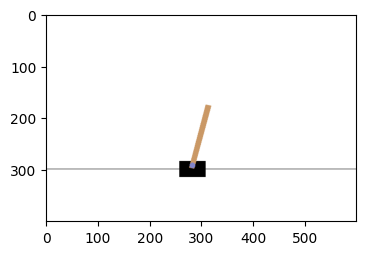

step: 10


In [20]:
visualize_policy(policy_net)

Now we define the objective/reward function. 
When the task is solved the functions returns -1000.
One successful trial is sufficient.

In [21]:
def fitness_cart_pole(x, nn, env):
    '''
    Returns negative accumulated reward for single pole, fully environment.

    Parameters:
        x: Parameter vector encoding the weights.
        nn: Parameterized model.
        env: Environment ('CartPole-v?').
    '''
    torch.nn.utils.vector_to_parameters(torch.Tensor(x), nn.parameters())  # Set the policy parameters
    
    state = env.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
          
    R = 0  # Accumulated reward
    while True:
        out = nn(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env.step(a)  # Simulate pole
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        R += reward  # Accumulate 
        if truncated:
            return -1000  # Episode ended, final goal reached, we consider minimization
        if terminated:
            return -R  # Episode ended, we consider minimization
    return -R  # Never reached  

Do the learning:

In [22]:
# Generate initial search point and initial hidden RNN states
initial_weights = np.random.normal(0, 0.01, d)  # Random parameters for initial policy, d denotes the number of weights
initial_sigma = .01 # Initial global step-size sigma

# Do the optimization
res = cma.fmin(fitness_cart_pole,  # Objective function
               initial_weights,  # Initial search point
               initial_sigma,  # Initial global step-size sigma
               args=([policy_net, env]),  # Arguments passed to the fitness function
               options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
env.close()

# Set the policy parameters to the final solution
torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), policy_net.parameters())  

print("best solution found after", res[2], "evaluations")

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 31 (seed=579650, Mon Feb 24 16:43:30 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.000000000000000e+01 1.0e+00 9.16e-03  9e-03  9e-03 0:00.0
    2     28 -1.100000000000000e+01 1.1e+00 8.74e-03  9e-03  9e-03 0:00.0
    3     42 -1.000000000000000e+01 1.1e+00 8.51e-03  8e-03  9e-03 0:00.1
   78   1092 -1.000000000000000e+03 2.0e+00 1.42e-02  1e-02  2e-02 0:02.3
termination on ftarget=-999.9 (Mon Feb 24 16:43:33 2025)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 1092/1083 evaluations
incumbent solution: [ 0.06099278 -0.01283798 -0.03361534 -0.04382624 -0.03625769  0.07061343
 -0.01004428  0.02149252 ...]
std deviations: [0.01432854 0.01406624 0.01334488 0.01433729 0.0139975  0.01466477
 0.01449673 0.01339545 ...]
best solution found after 1083 evaluations


Render solution:

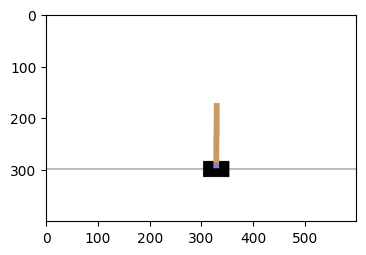

step: 500


In [23]:
visualize_policy(policy_net)

Learn more about CMA-ES optimization:

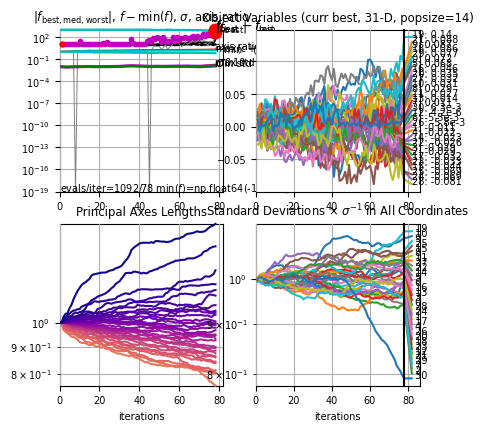

In [26]:
# Visualize the optimization 
cma.plot();  

In [27]:
# Learn even more on CMA-ES
cma.CMAOptions() 

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'CMA_active': 'True  # negative update, conducted after the original update',
 'CMA_active_injected': '0  #v weight multiplier for negative weights of injected solutions',
 'CMA_cmean': '1  # learning rate for the mean value',
 'CMA_const_trace': 'False  # normalize trace, 1, True, "arithm", "geom", "aeig", "geig" are valid',
 'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_diagonal_decoding': '0  # learning rate multiplier for additional diagonal update',
 'CMA_eigenmethod': 'np.linalg.eigh  # or cma.utilities.math.eig or pygsl.eigen.eigenvectors',
 'CMA_elitist': 'False  #v or "initial" or True, elitism likely impairs global search performance',
 'CMA_injections_threshold_keep_len': '1  #v keep length if Mahalanobis length is below the given relative threshold',
 'CMA_mirrors': 'popsize < 6  # values <0.5 are int